In [1]:
import os, glob, math
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms.functional import to_pil_image, resize

import matplotlib.pyplot as plt
from PIL import Image

import shap
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

/Users/dmorales/miniconda3/envs/LAB04-RIA/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cpu')

In [2]:
weights = MobileNet_V2_Weights.DEFAULT
model = mobilenet_v2(weights=weights).eval().to(device)
imagenet_classes = weights.meta["categories"] 

preprocess = weights.transforms()
input_size = (224, 224)
len(imagenet_classes), imagenet_classes[:5]

(1000, ['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead'])

In [3]:
def load_image(path, target_size=(224, 224)):
    img = Image.open(path).convert("RGB")
    img_224 = img.resize(target_size, resample=Image.BILINEAR)
    return img, img_224 

@torch.inference_mode()
def predict_paths(paths, topk=5):
    batch = []
    pil_224_list = []
    for p in paths:
        _, pil224 = load_image(p, target_size=input_size)
        pil_224_list.append(pil224)
        x = preprocess(pil224).unsqueeze(0)  
        batch.append(x)
    x = torch.cat(batch, dim=0).to(device)
    logits = model(x)
    probs = F.softmax(logits, dim=1).cpu().numpy()

    results = []
    for i, p in enumerate(paths):
        top_idx = probs[i].argsort()[::-1][:topk]
        results.append({
            "path": p,
            "topk_idx": top_idx,
            "topk_labels": [imagenet_classes[j] for j in top_idx],
            "topk_probs": probs[i][top_idx]
        })
    return probs, results, pil_224_list


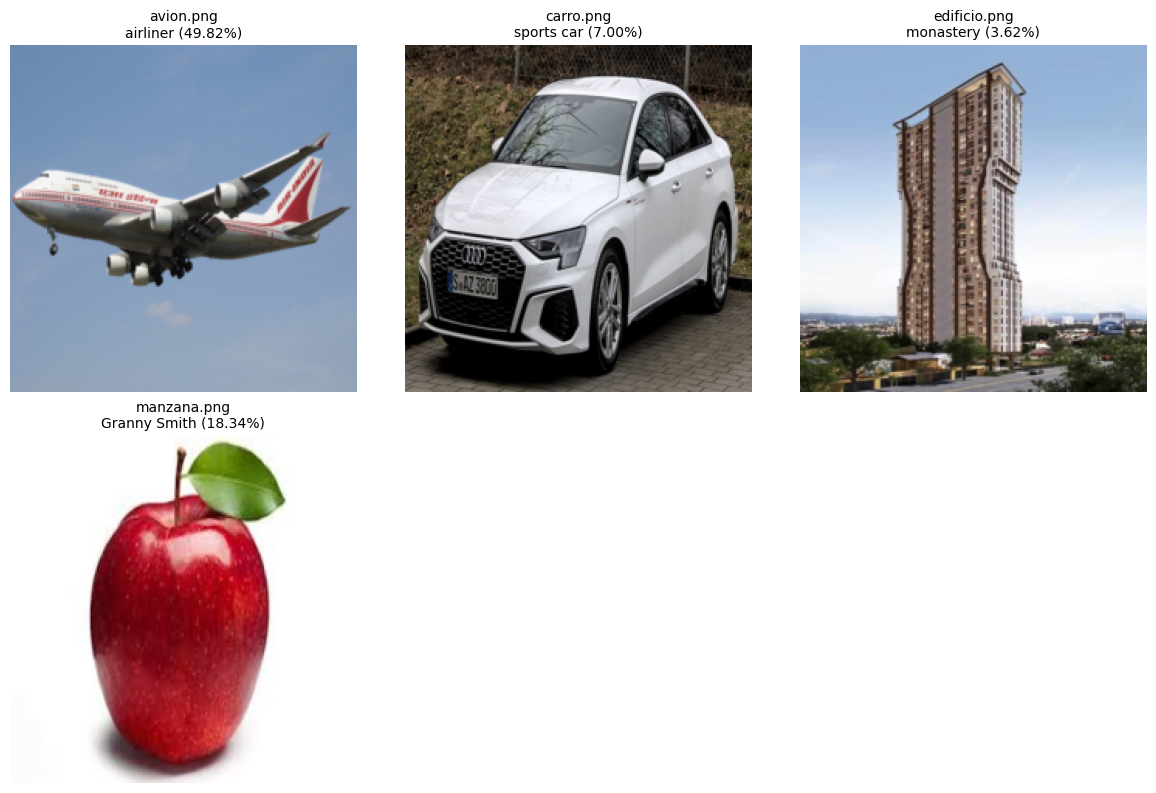


== avion.png ==
  airliner                             49.82%
  wing                                  3.96%
  warplane                              2.37%
  airship                               0.95%
  space shuttle                         0.45%

== carro.png ==
  sports car                            7.00%
  pickup                                6.49%
  beach wagon                           3.92%
  convertible                           2.50%
  racer                                 2.34%

== edificio.png ==
  monastery                             3.62%
  bell cote                             2.91%
  triumphal arch                        2.39%
  drilling platform                     1.46%
  pier                                  1.46%

== manzana.png ==
  Granny Smith                         18.34%
  pomegranate                           7.59%
  strawberry                            4.75%
  bell pepper                           1.77%
  lemon                                 1.36%


In [4]:
image_paths = sorted(glob.glob("./images/*.jpg")) + sorted(glob.glob("./images/*.png"))
assert len(image_paths) >= 2, "Agrega al menos 2 imágenes en ./images"

probs, results, pil_224_list = predict_paths(image_paths, topk=5)

cols = 3
rows = math.ceil(len(pil_224_list) / cols)
plt.figure(figsize=(4*cols, 4*rows))
for i, (pimg, info) in enumerate(zip(pil_224_list, results)):
    plt.subplot(rows, cols, i+1)
    plt.imshow(pimg)
    lbl = info["topk_labels"][0]
    pr  = info["topk_probs"][0]
    plt.title(f"{os.path.basename(info['path'])}\n{lbl} ({pr:.2%})", fontsize=10)
    plt.axis("off")
plt.tight_layout()
plt.show()

for r in results:
    print(f"\n== {os.path.basename(r['path'])} ==")
    for lbl, pr in zip(r["topk_labels"], r["topk_probs"]):
        print(f"  {lbl:35s}  {pr:6.2%}")


In [5]:
@torch.inference_mode()
def f_shap(nhwc_uint8_batch):
    if isinstance(nhwc_uint8_batch, list):
        X = np.stack(nhwc_uint8_batch, axis=0)
    else:
        X = nhwc_uint8_batch

    xs = []
    for i in range(X.shape[0]):
        pil = Image.fromarray(X[i].astype(np.uint8), mode="RGB")
        x = preprocess(pil).unsqueeze(0) 
        xs.append(x)
    x = torch.cat(xs, dim=0).to(device)

    logits = model(x)
    probs = F.softmax(logits, dim=1).cpu().numpy()
    return probs


In [6]:
import shap
print("SHAP:", shap.__version__)

masker = shap.maskers.Image("blur(128,128)", (224, 224, 3))

explainer = shap.Explainer(
    f_shap,
    masker=masker,
    output_names=imagenet_classes,
    algorithm="partition"
)

explainer


SHAP: 0.47.2


/var/folders/cj/gk9lc7jj0cs_ttmx57dq32cw0000gn/T/ipykernel_4377/2265325012.py:10: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  pil = Image.fromarray(X[i].astype(np.uint8), mode="RGB")


Predicción: airliner (49.82%)


/var/folders/cj/gk9lc7jj0cs_ttmx57dq32cw0000gn/T/ipykernel_4377/2265325012.py:10: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  pil = Image.fromarray(X[i].astype(np.uint8), mode="RGB")
PartitionExplainer explainer: 2it [00:35, 35.56s/it]               


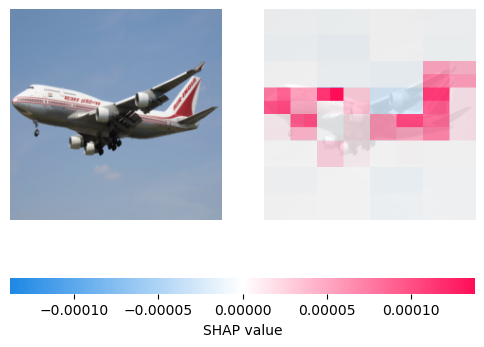

In [7]:
img_idx = 0
_, pil224 = load_image(image_paths[img_idx], target_size=input_size)

img_arr = np.array(pil224) 
X = img_arr[None, ...]      

p = f_shap(X)[0]
top_class = int(p.argmax())
top_label = imagenet_classes[top_class]
top_prob  = float(p[top_class])

print(f"Predicción: {top_label} ({top_prob:.2%})")

shap_values = explainer(X, max_evals=1000, batch_size=50)

shap.image_plot([shap_values.values[..., top_class]], X, show=True)


In [10]:
N = min(4, len(image_paths) + 1)
imgs_224 = []
for i in range(N):
    _, pil224 = load_image(image_paths[i], target_size=input_size)
    imgs_224.append(np.array(pil224))
XN = np.stack(imgs_224, axis=0)  

svs = explainer(XN, max_evals=800, batch_size=20)

os.makedirs("shap_outputs", exist_ok=True)
for i in range(N):
    probs_i = f_shap(XN[i:i+1])[0]
    c = int(probs_i.argmax())
    lbl = imagenet_classes[c]

    shap.image_plot([svs.values[i][..., c]], XN[i], show=False)

    fig = plt.gcf()
    fig.suptitle(lbl, y=0.98)
    out = f"shap_outputs/exp_{i}_{lbl.replace(' ','_')}.png"
    fig.savefig(out, dpi=180, bbox_inches="tight")
    plt.close(fig)
    print(f"Guardado: {out}")


/var/folders/cj/gk9lc7jj0cs_ttmx57dq32cw0000gn/T/ipykernel_4377/2265325012.py:10: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  pil = Image.fromarray(X[i].astype(np.uint8), mode="RGB")
 99%|█████████▉| 790/798 [00:25<00:00, 23.68it/s]
810it [00:25, 22.70it/s]                         
818it [00:29, 10.10it/s]
 99%|█████████▉| 790/798 [00:24<00:00, 27.38it/s]
810it [00:25, 27.41it/s]                         
818it [00:27, 14.80it/s]
 99%|█████████▉| 790/798 [00:28<00:00, 14.93it/s]
810it [00:29, 15.62it/s]                         
818it [00:32,  9.73it/s]
PartitionExplainer explainer: 5it [02:29, 37.38s/it]                       


Guardado: shap_outputs/exp_0_airliner.png
Guardado: shap_outputs/exp_1_sports_car.png
Guardado: shap_outputs/exp_2_monastery.png
Guardado: shap_outputs/exp_3_Granny_Smith.png


## Reflexion 

1. ¿Coinciden las áreas resaltadas con el objeto que aparece en la imagen?

Al observar los mapas de calor generados por SHAP, se puede notar que las áreas resaltadas sí coinciden, en buena medida, con los objetos presentes en cada imagen. En el caso del avión, las regiones destacadas corresponden a las alas y el fuselaje, que son precisamente los rasgos más representativos de un avión. Con la manzana, el modelo se enfocó en la zona del tallo y la hoja, un detalle que resulta muy distintivo para diferenciar una fruta real de otro objeto de color y forma similar. En el carro, las partes resaltadas se encuentran en el frente del vehículo, la parrilla y los faros, que son componentes característicos para identificarlo. Finalmente, en el edificio clasificado como “monastery”, las áreas resaltadas se concentran en la estructura central y superior, lo que refleja que el modelo reconoce patrones arquitectónicos en la silueta y las ventanas.

2. ¿El modelo se enfocó en regiones relevantes?
En términos de relevancia, se puede afirmar que el modelo sí se enfocó en regiones significativas. No se trata de un aprendizaje superficial basado únicamente en el fondo de la imagen, sino en elementos propios del objeto principal. El avión es reconocido por sus alas, la manzana por su tallo y hoja, el carro por su forma frontal, y el edificio por su estructura vertical. Esto indica que, en general, el modelo está extrayendo información útil y coherente con lo que un humano también consideraría importante para identificar cada categoría.


3. Si el modelo se equivocó, ¿qué revelan las explicaciones sobre la confusión?
El modelo se equivocó clasificando un edificio como un “monastery”. Aquí, las explicaciones muestran que el error no fue producto del azar, sino de una confusión visual comprensible: la red neuronal asoció la altura, la simetría y los patrones de ventanas del edificio con características que también pueden encontrarse en estructuras religiosas. En otras palabras, el modelo tiende a generalizar la idea de “monasterio” como cualquier construcción alta y alargada, sin distinguir entre arquitectura moderna y arquitectura antigua. Este tipo de explicación revela las limitaciones del modelo y ayuda a entender cómo se producen ciertos errores de clasificación.



